In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import math
import torch
from torch.utils.data import DataLoader

import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
# from torch import vmap
from functorch import vmap, grad
from models import FNN2d, FNN3d
from train_utils import Adam
# from train_utils.datasets import BurgersLoader
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.WaveEq import WaveEq1D, WaveEq2D
from solver.BurgersEq import BurgersEq1D, BurgersEq2D
import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import traceback
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from tqdm import tqdm
from train_utils.utils import save_checkpoint, get_grid3d, convert_ic, torch2dgrid
from train_utils.losses import LpLoss, darcy_loss, PINO_loss, PINO_loss3d, get_forcing

from solver.random_fields import GaussianRF
from solver.my_random_fields import GRF_Mattern
from GRF import construct_grid, construct_points, RBF, dirichlet_matern, neumann_matern, periodic_matern, get_cholesky, generate_sample, generate_samples, plot_sample, setup_kernel
import GRF
from importlib import reload
GRF = reload(GRF)

try:
    import wandb
except ImportError:
    wandb = None


# Checkpoint Loading

In [2]:
def load_checkpoint(model, ckpt_path, optimizer=None):
    try:
        ckpt = torch.load(ckpt_path)
        model.load_state_dict(ckpt['model'])
        print('Weights loaded from %s' % ckpt_path)
        if optimizer is not None:
            try:
                optimizer.load_state_dict(ckpt['optim'])
                print('Optimizer loaded from %s' % ckpt_path)
            except: traceback.print_exc()
            
    except:
        traceback.print_exc()

# Load/Update Config Functions:

In [3]:
def update_config(config, file):
    with open(file, 'w') as f:
        config_updated = yaml.dump(config, f)
        
def load_config(file):
    with open(file, 'r') as f:
        config = yaml.load(f, yaml.FullLoader)
    return config

# Define DataLoader Class for 2D Data

In [4]:
class DataLoader2D(object):
    def __init__(self, data, nx=128, nt=100, sub=1, sub_t=1):
#         dataloader = MatReader(datapath)
        self.sub = sub
        self.sub_t = sub_t            
        s = nx
        # if nx is odd
        if (s % 2) == 1:
            s = s - 1
        self.S = s // sub
        self.T = nt // sub_t
        self.T += 1
        data = data[:, 0:self.T:sub_t, 0:self.S:sub, 0:self.S:sub]
        self.data = data.permute(0, 2, 3, 1)
        
    def make_loader(self, n_sample, batch_size, start=0, train=True):
        a_data = self.data[start:start + n_sample, :, :, 0].reshape(n_sample, self.S, self.S)
        u_data = self.data[start:start + n_sample].reshape(n_sample, self.S, self.S, self.T)
#         Xs = self.x_data[start:start + n_sample].reshape(n_sample, self.S, self.S)
#         ys = self.y_data[start:start + n_sample].reshape(n_sample, self.S, self.S, self.T)
        gridx, gridy, gridt = get_grid3d(self.S, self.T)
        a_data = a_data.reshape(n_sample, self.S, self.S, 1, 1).repeat([1, 1, 1, self.T, 1])
        a_data = torch.cat((gridx.repeat([n_sample, 1, 1, 1, 1]),
                            gridy.repeat([n_sample, 1, 1, 1, 1]),
                            gridt.repeat([n_sample, 1, 1, 1, 1]),
                            a_data), dim=-1)
        dataset = torch.utils.data.TensorDataset(a_data, u_data)
        if train:
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        else:
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        return loader

# Define Loss Function For Automatic Differentiation

In [5]:
def Autograd_Burgers2D(u, grid, nu=0.01):
    from torch.autograd import grad
    u2 = u**2
    gridx, gridy, gridt = grid
    ut = grad(u.sum(), gridt, create_graph=True)[0]
    ux = grad(u.sum(), gridx, create_graph=True)[0]
    uy = grad(u.sum(), gridy, create_graph=True)[0]
    uxx = grad(ux.sum(), gridx, create_graph=True)[0]
    uyy = grad(uy.sum(), gridy, create_graph=True)[0]
    u2x = grad(u2.sum(), gridx, create_graph=True)[0]
    u2y = grad(u2.sum(), gridy, create_graph=True)[0]
    Du = ut + 0.5*(u2x + u2y) - nu*(uxx + uyy)
    return Du, uxx, uyy, utt


def AD_loss_Burgers2D(u, u0, grid, index_ic=None, p=None, q=None, nu=0.01):
    batchsize = u.size(0)
    # lploss = LpLoss(size_average=True)

    Du, uxx, uyy, utt = Autograd_Burgers(u, grid, nu=nu)

    if index_ic is None:
        # u in on a uniform grid
        nx = u.size(1)
        ny = u.size(2)
        nt = u.size(3)
        u = u.reshape(batchsize, nx, ny, nt)

        index_t = torch.zeros(nx,).long()
        index_x = torch.tensor(range(nx)).long()
        boundary_u = u[:, index_t, index_x]

        # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
        # loss_bc1 = F.mse_loss(ux[:, :, 0], ux[:, :, -1])
    else:
        # u is randomly sampled, 0:p are BC, p:2p are ic, 2p:2p+q are interior
        boundary_u = u[:, :p]
        batch_index = torch.tensor(range(batchsize)).reshape(batchsize, 1).repeat(1, p)
        u0 = u0[batch_index, index_ic]

        # loss_bc0 = F.mse_loss(u[:, p:p+p//2], u[:, p+p//2:2*p])
        # loss_bc1 = F.mse_loss(ux[:, p:p+p//2], ux[:, p+p//2:2*p])

    loss_ic = F.mse_loss(boundary_u, u0)
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)
    return loss_ic, loss_f

# Define Loss for Fourier Derivatives

In [6]:
def FDM_Burgers2D(u, D=1, nu=0.01):
    batchsize = u.size(0)
    nx = u.size(1)
    ny = u.size(2)
    nt = u.size(3)
    u = u.reshape(batchsize, nx, ny, nt)
    dt = D / (nt-1)
    dx = D / (nx)
    u2 = u**2
    u_h = torch.fft.fftn(u, dim=[1, 2])
    u2_h = torch.fft.fftn(u2, dim=[1, 2])
    # Wavenumbers in y-direction
    k_max = nx//2
    N = nx
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                     torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(N, 1).repeat(1, N).reshape(1,N,N,1)
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                     torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(1, N).repeat(N, 1).reshape(1,N,N,1)
    ux_h = 2j *np.pi*k_x*u_h
    uxx_h = 2j *np.pi*k_x*ux_h
    uy_h = 2j *np.pi*k_y*u_h
    uyy_h = 2j *np.pi*k_y*uy_h
    u2x_h = 2j *np.pi*k_x*u2_h
    u2y_h = 2j *np.pi*k_y*u2_h
#     ux = torch.fft.irfftn(ux_h[:, :, :k_max+1], dim=[1, 2])
#     uy = torch.fft.irfftn(uy_h[:, :, :k_max+1], dim=[1, 2])
    uxx = torch.fft.irfftn(uxx_h[:, :, :k_max+1], dim=[1, 2])
    uyy = torch.fft.irfftn(uyy_h[:, :, :k_max+1], dim=[1, 2])
    u2x = torch.fft.irfftn(u2x_h[:, :, :k_max+1], dim=[1, 2])
    u2y = torch.fft.irfftn(u2y_h[:, :, :k_max+1], dim=[1, 2])
    ut = (u[..., 2:] - u[..., :-2]) / (2 * dt)
#     utt = (u[..., 2:] - 2.0*u[..., 1:-1] + u[..., :-2]) / (dt**2)
    Du = ut + (0.5*(u2x + u2y) - nu*(uxx + uyy))[..., 1:-1]
#     Du = ut + (u*(ux + uy) - nu*(uxx + uyy))[..., 1:-1]
    return Du


def PINO_loss_burgers2D(u, u0, nu=0.01):
    batchsize = u.size(0)
    nx = u.size(1)
    ny = u.size(2)
    nt = u.size(3)
    u = u.reshape(batchsize, nx, ny, nt)

    lploss = LpLoss(size_average=True)
    u_ic = u[..., 0]
    loss_ic = lploss(u_ic, u0)
#     index_t = torch.zeros(nx,).long()
#     index_x = torch.tensor(range(nx)).long()
#     boundary_u = u[:, index_t, index_x]
#     loss_u = F.mse_loss(boundary_u, u0)

#     Du = FDM_Burgers(u, nu=nu)[:, :, :, :]
    Du = FDM_Burgers2D(u, nu=nu)
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_ic, loss_f

# Define Training Fuction

In [7]:
def train_burgers2d(model,
                 dataset,
                 train_loader,
                 optimizer, scheduler,
                 config,
                 nu=0.01,
                 rank=0, log=False,
                 project='PINO-2d-default',
                 group='default',
                 tags=['default'],
                 use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    S, T = dataset.S, dataset.T
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        train_ic = 0.0
        data_l2 = 0.0
        train_loss = 0.0
        

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            loss_ic, loss_f = PINO_loss_burgers2D(out, x[..., 0, -1], nu=nu)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()

            total_loss.backward()
            optimizer.step()
            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_ic += loss_ic.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_ic /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [8]:
def train_burgers2d_pad(model,
                 dataset,
                 train_loader,
                 optimizer, scheduler,
                 config,
                 nu=0.01, padding=0,
                 rank=0, log=False,
                 project='PINO-2d-default',
                 group='default',
                 tags=['default'],
                 use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    S, T = dataset.S, dataset.T
    batch_size = config['train']['batchsize']
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        train_ic = 0.0
        data_l2 = 0.0
        train_loss = 0.0
        

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            x_in = F.pad(x, (0, 0, 0, padding), "constant", 0)
            out = model(x_in).reshape(batch_size, S, S, T + padding)
            out = out[..., :-padding]
            u0 = x[..., 0, -1]
            
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_ic, loss_f = PINO_loss_burgers2D(out, u0, nu=nu)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()

            total_loss.backward()
            optimizer.step()
            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_ic += loss_ic.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_ic /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

# Define Eval Function

In [9]:
def eval_burgers2D(model,
                dataloader,
                config,
                device,
                nu=0.01,
                use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_ic, f_loss = PINO_loss_burgers2D(out, x[..., 0, -1], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



In [10]:
def eval_burgers2D_pad(model,
                       dataloader,
                       config,
                       device,
                       nu=0.01, padding=0,
                       use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            batch_size, S, S, T = y.shape
            x_in = F.pad(x, (0, 0, 0, padding), "constant", 0)
            out = model(x_in).reshape(batch_size, S, S, T + padding)
            out = out[..., :-padding]
            u0 = x[..., 0, -1]
            
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_ic, loss_f = PINO_loss_burgers2D(out, u0, nu=nu)
#             total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

#             out = model(x).reshape(y.shape)
#             data_loss = myloss(out, y)

#             loss_ic, f_loss = PINO_loss_burgers2D(out, x[..., 0, -1], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(loss_f.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



# Define Parameters

In [33]:
dim = 2
N = 128
Nx = N
Ny = N
l = 0.1
L = 1.0
sigma = 2.0
nu = 0.01
Nu = 2.0
Nsamples = 50
jitter = 1e-12
dt = 1.0e-4
save_int = int(1e-2/dt)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Generate Random Fields

In [34]:
# grf = GaussianRF(dim, N, length=1.0, alpha=2.5, tau=5.0, sigma=None, device=device)
# U0 = grf.sample(Nsamples)

In [35]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)

In [36]:
U0.std()

tensor(0.4571, device='cuda:0')

In [37]:
u0 = U0[0].cpu()
u0

tensor([[-0.8077, -0.8286, -0.8400,  ..., -0.7077, -0.7372, -0.7786],
        [-0.8612, -0.8689, -0.8592,  ..., -0.7520, -0.7891, -0.8350],
        [-0.8718, -0.8696, -0.8533,  ..., -0.7767, -0.8163, -0.8554],
        ...,
        [-0.6645, -0.7229, -0.7382,  ..., -0.5194, -0.5740, -0.6172],
        [-0.7132, -0.7579, -0.7699,  ..., -0.5897, -0.6304, -0.6719],
        [-0.7596, -0.7852, -0.8034,  ..., -0.6475, -0.6776, -0.7244]])

In [38]:
u0.shape

torch.Size([128, 128])

# Plot Random Fields

In [39]:
key = 1
x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
u0 = U0[key].cpu().numpy()
u0

array([[-0.26935425, -0.3157668 , -0.34523982, ..., -0.09343609,
        -0.15403408, -0.21311706],
       [-0.26660782, -0.31400466, -0.35563824, ..., -0.06757329,
        -0.13874069, -0.20988308],
       [-0.24361813, -0.29666984, -0.3454379 , ..., -0.04895846,
        -0.12554167, -0.1905941 ],
       ...,
       [-0.22567251, -0.21614766, -0.1926355 , ..., -0.21398544,
        -0.21361668, -0.22217095],
       [-0.25721133, -0.25741145, -0.24700439, ..., -0.183483  ,
        -0.198575  , -0.22608212],
       [-0.26575118, -0.2926166 , -0.3035713 , ..., -0.13149387,
        -0.16653079, -0.21046497]], dtype=float32)

<IPython.core.display.Javascript object>


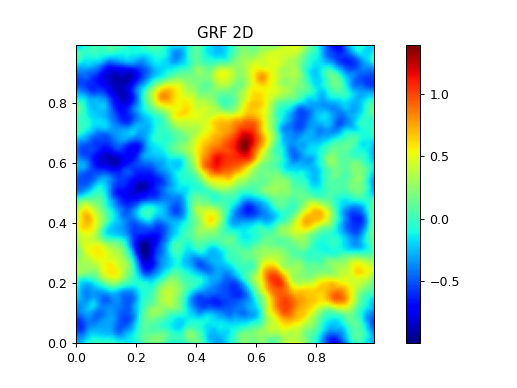

In [40]:
fig = plt.figure()
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(X, Y, u0, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
c = plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')

# fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(c)

plt.title('GRF 2D')
plt.axis('square')
plt.show()

<IPython.core.display.Javascript object>


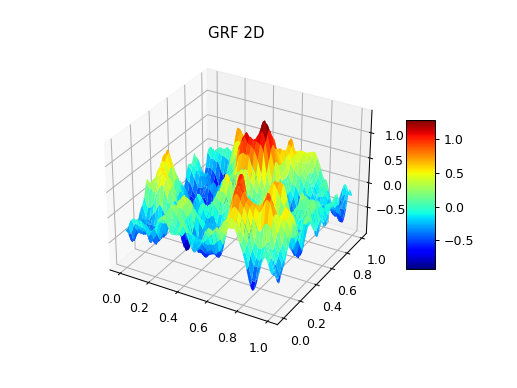

In [41]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, u0, cmap='jet', linewidth=0, antialiased=True,)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('GRF 2D')
plt.show()



# Evolve the Wave Equation

In [42]:
burgers_eq = BurgersEq2D(Nx=Nx, Ny=Ny, dt=dt, nu=nu, device=device)
U = vmap(burgers_eq.burgers_driver, in_dims=(0, None))(U0, save_int)

In [43]:
a = U0.cpu().float()
u = U.cpu().float()
display(u.shape,a.shape)

torch.Size([50, 101, 128, 128])

torch.Size([50, 128, 128])

In [44]:
u

tensor([[[[-8.0766e-01, -8.2859e-01, -8.3997e-01,  ..., -7.0771e-01,
           -7.3717e-01, -7.7860e-01],
          [-8.6117e-01, -8.6890e-01, -8.5919e-01,  ..., -7.5198e-01,
           -7.8908e-01, -8.3497e-01],
          [-8.7177e-01, -8.6960e-01, -8.5335e-01,  ..., -7.7672e-01,
           -8.1627e-01, -8.5535e-01],
          ...,
          [-6.6451e-01, -7.2288e-01, -7.3820e-01,  ..., -5.1942e-01,
           -5.7401e-01, -6.1720e-01],
          [-7.1320e-01, -7.5785e-01, -7.6987e-01,  ..., -5.8966e-01,
           -6.3037e-01, -6.7188e-01],
          [-7.5963e-01, -7.8520e-01, -8.0344e-01,  ..., -6.4746e-01,
           -6.7756e-01, -7.2439e-01]],

         [[-8.0328e-01, -8.0265e-01, -7.9446e-01,  ..., -7.3525e-01,
           -7.6971e-01, -7.9260e-01],
          [-8.0224e-01, -8.0205e-01, -7.9743e-01,  ..., -7.4033e-01,
           -7.7302e-01, -7.9336e-01],
          [-7.8031e-01, -7.8318e-01, -7.8399e-01,  ..., -7.1727e-01,
           -7.5008e-01, -7.7041e-01],
          ...,
     

# Plot Data

<IPython.core.display.Javascript object>


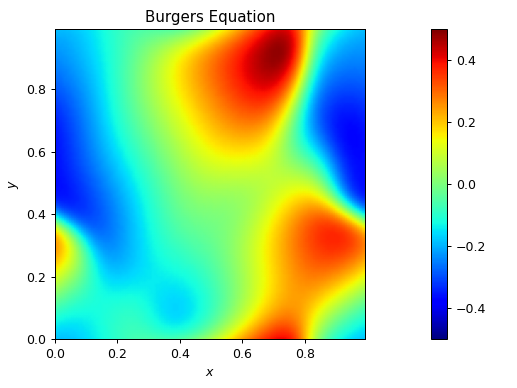

In [45]:
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0

pcm = ax.pcolormesh(X, Y, u[key, 0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(pcm, ax=ax)
# ax.

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation')
plt.axis('square')
plt.tight_layout()

# movie_dir = "Wave2D_movie"
# movie_filename = "Wave2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
    pcm = ax.pcolormesh(X, Y, u[key, i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
#     plt.colorbar(pcm, ax=ax)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Burgers Equation')
    plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)

<IPython.core.display.Javascript object>


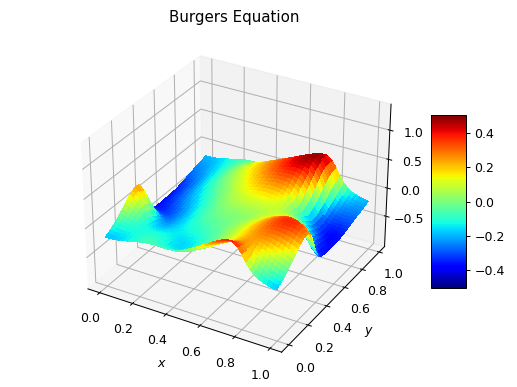

In [46]:
# %matplotlib notebook
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
surf = ax.plot_surface(X, Y, u[key, 0].cpu().numpy(), cmap='jet', vmin=-0.5, vmax=0.5, linewidth=0, antialiased=False)

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(surf, ax=ax)
fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax.get_zlim()
ax.set_zlim(zlim)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation')
# plt.axis('square')
plt.tight_layout()

# movie_dir = "Wave2D_movie"
# movie_filename = "Wave2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
    surf = ax.plot_surface(X, Y, u[key, i].cpu().numpy(), cmap='jet', vmin=-0.5, vmax=0.5, linewidth=0, antialiased=False)
    ax.set_zlim(zlim)
#     plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
#     ax.set_zlabel('$u$')
    plt.title(f'Burgers Equation')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



# Load Configuration File

In [47]:
config_file = 'configs/custom/burgers2D-0002.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Burgers2D-0002',
  'total_num': 50,
  'n_train': 45,
  'n_test': 5,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [64, 64, 64, 64, 64],
  'modes1': [8, 8, 8, 8],
  'modes2': [8, 8, 8, 8],
  'modes3': [8, 8, 8, 8],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 1,
  'epochs': 150,
  'milestones': [25, 50, 75, 100],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 10.0,
  'f_loss': 1.0,
  'xy_loss': 1.0,
  'save_dir': 'Burgers2D',
  'save_name': 'Burgers2D-0002.pt',
  'ckpt': 'checkpoints/Burgers2D/Burgers2D-0002.pt',
  'ckpt_freq': 25},
 'log': {'project': 'PINO-Burgers', 'group': 'Burgers2D-0002'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Burgers2D/Burgers2D-0002.pt'}}

# Define the DataLoaders

In [48]:
dataset = DataLoader2D(u, config['data']['nx'], config['data']['nt'], config['data']['sub'], config['data']['sub_t'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

# Define the Model

In [49]:
log = False
# config = config_train
model = FNN3d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              modes3=config['model']['modes3'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'], 
              activation=config['model']['activation'],
             ).to(device)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

# Load from checkpoint

In [50]:
load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)
# load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=optimizer)

Weights loaded from checkpoints/Burgers2D/Burgers2D-0002.pt


# Train the Model

In [51]:
train_burgers2d_pad(model,
                dataset,
                train_loader,
                optimizer,
                scheduler,
                config,
                nu=config['data']['nu'],
                padding=5,
                rank=0,
                log=log,
                project=config['log']['project'],
                group=config['log']['group'])

  0%|          | 0/150 [00:00<?, ?it/s]/jet/home/shawngr2/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:237.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0, train loss: 1.20147 train f error: 0.25237; data l2 error: 0.16405; train ic error: 0.07851:   1%|          | 1/150 [00:20<51:55, 20.91s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0002_0.pt


Epoch 25, train loss: 0.31997 train f error: 0.05704; data l2 error: 0.04643; train ic error: 0.02165:  17%|█▋        | 26/150 [08:31<40:45, 19.72s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0002_25.pt


Epoch 50, train loss: 0.19949 train f error: 0.04140; data l2 error: 0.02725; train ic error: 0.01308:  34%|███▍      | 51/150 [16:42<32:31, 19.71s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0002_50.pt


Epoch 75, train loss: 0.11327 train f error: 0.03612; data l2 error: 0.01934; train ic error: 0.00578:  51%|█████     | 76/150 [24:54<24:18, 19.71s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0002_75.pt


Epoch 100, train loss: 0.07658 train f error: 0.03409; data l2 error: 0.01527; train ic error: 0.00272:  67%|██████▋   | 101/150 [33:04<16:04, 19.68s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0002_100.pt


Epoch 125, train loss: 0.07130 train f error: 0.03330; data l2 error: 0.01431; train ic error: 0.00237:  84%|████████▍ | 126/150 [41:14<07:52, 19.69s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0002_125.pt


Epoch 149, train loss: 0.07339 train f error: 0.03255; data l2 error: 0.01368; train ic error: 0.00272: 100%|██████████| 150/150 [49:04<00:00, 19.63s/it]


Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0002.pt
Done!


In [50]:
train_burgers2d(model,
             dataset,
             train_loader,
             optimizer,
             scheduler,
             config,
             nu=config['data']['nu'],
             rank=0,
             log=log,
             project=config['log']['project'],
             group=config['log']['group'])

  0%|          | 0/150 [00:00<?, ?it/s]/jet/home/shawngr2/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:237.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0, train loss: 5.36019 train f error: 0.57932; data l2 error: 0.77547; train ic error: 0.40054:   1%|          | 1/150 [00:21<53:15, 21.44s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0001_0.pt


Epoch 25, train loss: 0.73511 train f error: 0.07134; data l2 error: 0.14662; train ic error: 0.05171:  17%|█▋        | 26/150 [08:40<41:28, 20.07s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0001_25.pt


Epoch 50, train loss: 0.32050 train f error: 0.04975; data l2 error: 0.06783; train ic error: 0.02029:  34%|███▍      | 51/150 [16:59<33:03, 20.04s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0001_50.pt


Epoch 75, train loss: 0.19138 train f error: 0.03866; data l2 error: 0.04777; train ic error: 0.01049:  51%|█████     | 76/150 [25:19<24:45, 20.07s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0001_75.pt


Epoch 100, train loss: 0.12715 train f error: 0.03267; data l2 error: 0.04030; train ic error: 0.00542:  67%|██████▋   | 101/150 [33:38<16:22, 20.05s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0001_100.pt


Epoch 125, train loss: 0.11141 train f error: 0.02984; data l2 error: 0.03746; train ic error: 0.00441:  84%|████████▍ | 126/150 [41:58<08:01, 20.06s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0001_125.pt


Epoch 149, train loss: 0.10717 train f error: 0.02727; data l2 error: 0.03487; train ic error: 0.00450: 100%|██████████| 150/150 [49:55<00:00, 19.97s/it]


Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0001.pt
Done!


### Old Model for Comparison (Trained Twice)

In [73]:
train_burgers2d(model,
             dataset,
             train_loader,
             optimizer,
             scheduler,
             config,
             nu=config['data']['nu'],
             rank=0,
             log=log,
             project=config['log']['project'],
             group=config['log']['group'])

Epoch 0, train loss: 0.14738 train f error: 0.04311; data l2 error: 0.05863; train ic error: 0.00456:   1%|          | 1/150 [00:21<53:23, 21.50s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0000_0.pt


Epoch 25, train loss: 0.14728 train f error: 0.04070; data l2 error: 0.05498; train ic error: 0.00516:  17%|█▋        | 26/150 [08:41<41:33, 20.11s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0000_25.pt


Epoch 50, train loss: 0.13805 train f error: 0.03863; data l2 error: 0.05168; train ic error: 0.00477:  34%|███▍      | 51/150 [17:05<33:24, 20.25s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0000_50.pt


Epoch 75, train loss: 0.14169 train f error: 0.03680; data l2 error: 0.04858; train ic error: 0.00563:  51%|█████     | 76/150 [25:27<24:53, 20.19s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0000_75.pt


Epoch 100, train loss: 0.12108 train f error: 0.03522; data l2 error: 0.04551; train ic error: 0.00403:  67%|██████▋   | 101/150 [33:49<16:27, 20.15s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0000_100.pt


Epoch 125, train loss: 0.13813 train f error: 0.03353; data l2 error: 0.04303; train ic error: 0.00616:  84%|████████▍ | 126/150 [42:11<08:03, 20.14s/it]

Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0000_125.pt


Epoch 149, train loss: 0.15022 train f error: 0.03226; data l2 error: 0.04069; train ic error: 0.00773: 100%|██████████| 150/150 [50:11<00:00, 20.08s/it]


Checkpoint is saved at checkpoints/Burgers2D/Burgers2D-0000.pt
Done!


# Evaluate Model

In [40]:
eval_burgers2D(model,
            test_loader,
            config,
            device,
            nu=config['data']['nu'],
            use_tqdm=True)

 40%|████      | 2/5 [00:00<00:01,  2.38it/s]


RuntimeError: CUDA out of memory. Tried to allocate 408.00 MiB (GPU 0; 15.78 GiB total capacity; 11.23 GiB already allocated; 228.75 MiB free; 12.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [52]:
eval_burgers2D_pad(model,
            test_loader,
            config,
            device,
            nu=config['data']['nu'],
                   padding=5,
            use_tqdm=True)

100%|██████████| 5/5 [00:00<00:00,  7.20it/s]

==Averaged relative L2 error mean: 0.057887278497219086, std error: 0.00806109332920394==
==Averaged equation error mean: 0.07929258570075035, std error: 0.020841112999888705==


# Generate Test Predictions

In [53]:
Nx = config['data']['nx']
Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nx,Ny,Nt,4))
preds_y = np.zeros((Ntest,Nx,Ny,Nt))
test_y = np.zeros((Ntest,Nx,Ny,Nt))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

## Padding

In [54]:
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nx,Ny,Nt,4))
preds_y = np.zeros((Ntest,Nx,Ny,Nt))
test_y = np.zeros((Ntest,Nx,Ny,Nt))

with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding)
        pred_y = pred_y_pad[..., :-padding].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

# Plot Results

In [55]:
key = 0
key_t = Nt - 1
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
# Nt, Nx, _ = a.shape
u0 = a[..., 0, -1]
pred_t = pred[..., key_t]
true_t = true[..., key_t]
# T = a[:,:,2]
# X = a[:,:,1]
# x = X[0]
x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
t = a[0, 0, key_t, 2]
grid_x, grid_y, grid_t = get_grid3d(Nx, Nt)
# X = X.reshape(Nx, Nx)

<IPython.core.display.Javascript object>


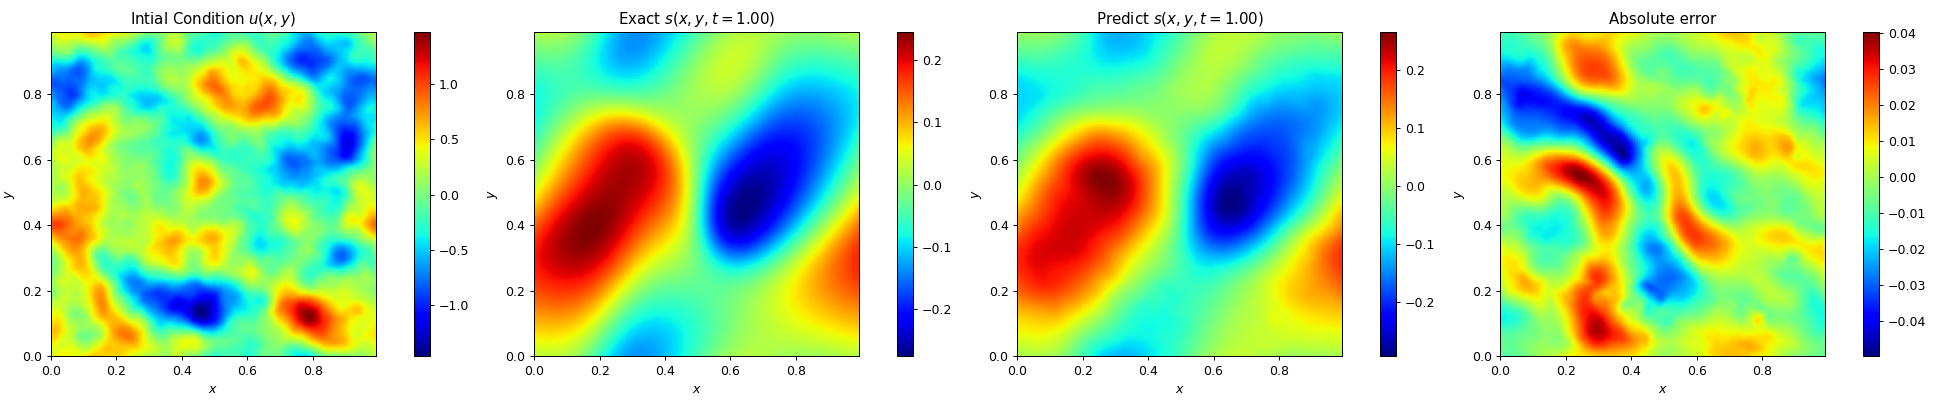

(0.0, 0.9921875, 0.0, 0.9921875)

In [56]:
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Intial Condition $u(x,y)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, Y, true_t, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $s(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, Y, pred_t, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $s(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, Y, pred_t - true_t, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

# plt.show()

<IPython.core.display.Javascript object>


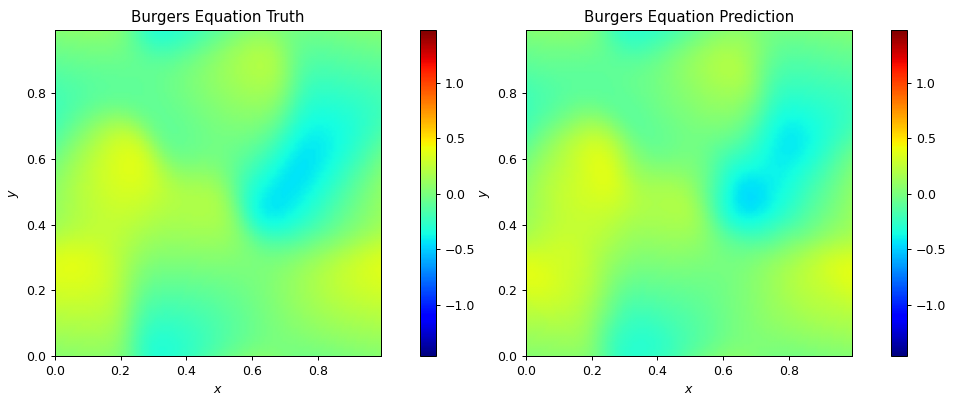

In [57]:
# %matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
# pcm1 = ax1.plot_pcmace(X, Y, true[..., 0], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
pcm1 = ax1.pcolormesh(X, Y, true[..., 0], cmap='jet', label='true', shading='gouraud')

# plt.colorbar()
# pcm2 = ax2.plot_pcmace(X, Y, pred[..., 0], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
pcm2 = ax2.pcolormesh(X, Y, pred[..., 0], cmap='jet', label='pred', shading='gouraud')

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.05)


# fig.colorbar(pcm, shrink=0.5, aspect=5)

# ax.
# ax.set_clim(-1, 1)
# display(ax.get_clim())
clim = pcm1.get_clim()
pcm1.set_clim(clim)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
pcm2.set_clim(clim)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_title(f'Burgers Equation Truth')
ax2.set_title(f'Burgers Equation Prediction')

# plt.axis('square')

plt.colorbar(pcm1, ax=ax1)
plt.colorbar(pcm2, ax=ax2)
ax1.axis('square')
ax2.axis('square')
plt.tight_layout()
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax1.clear()
    ax2.clear()
    pcm1 = ax1.pcolormesh(X, Y, true[..., i], cmap='jet', label='true', shading='gouraud')

    pcm2 = ax2.pcolormesh(X, Y, pred[..., i], cmap='jet', label='pred', shading='gouraud')
#     plt.axis('square')

    pcm1.set_clim(clim)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    pcm2.set_clim(clim)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax1.set_title(f'Burgers Equation Truth')
    ax2.set_title(f'Burgers Equation Prediction')
#     plt.title(f'Burgers Equation')
    ax1.axis('square')
    ax2.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>


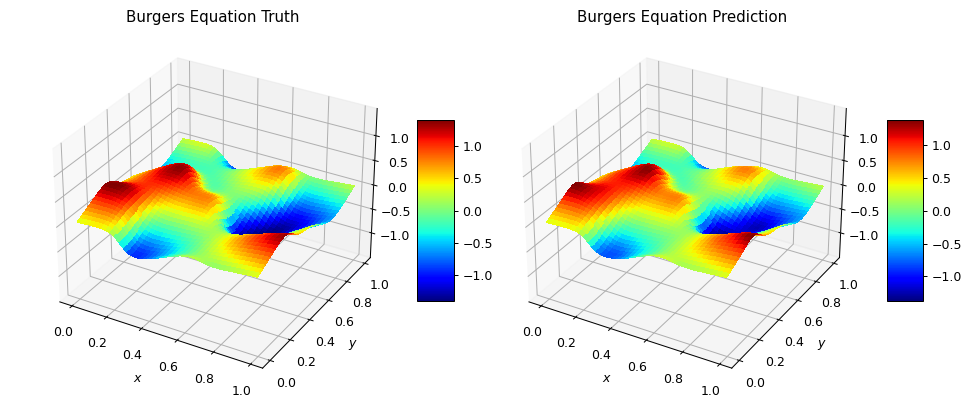

In [58]:
# %matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), subplot_kw={"projection": "3d"})

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
# surf1 = ax1.plot_surface(X, Y, true[..., 0], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
surf1 = ax1.plot_surface(X, Y, true[..., 0], cmap='jet', label='true', linewidth=0.0, antialiased=False)

# plt.colorbar()
# surf2 = ax2.plot_surface(X, Y, pred[..., 0], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, pred[..., 0], cmap='jet', label='pred',linewidth=0.0, antialiased=False)

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.05)


# fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax1.get_zlim()
ax1.set_zlim(zlim)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.set_zlim(zlim)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_title(f'Burgers Equation Truth')
ax2.set_title(f'Burgers Equation Prediction')
# plt.axis('square')

plt.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
plt.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.tight_layout()
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax1.clear()
    ax2.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
#     surf1 = ax1.plot_surface(X, Y, true[..., i], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
    surf1 = ax1.plot_surface(X, Y, true[..., i], cmap='jet', label='true', linewidth=0.0, antialiased=False)
#     surf2 = ax2.plot_surface(X, Y, pred[..., i], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
    surf2 = ax2.plot_surface(X, Y, pred[..., i], cmap='jet', label='pred',linewidth=0.0, antialiased=False)

    ax1.set_zlim(zlim)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax2.set_zlim(zlim)
    ax2.set_xlabel('$x$')
    
    ax2.set_ylabel('$y$')
    ax1.set_title(f'Burgers Equation Truth')
    ax2.set_title(f'Burgers Equation Prediction')
#     plt.title(f'Burgers Equation')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>


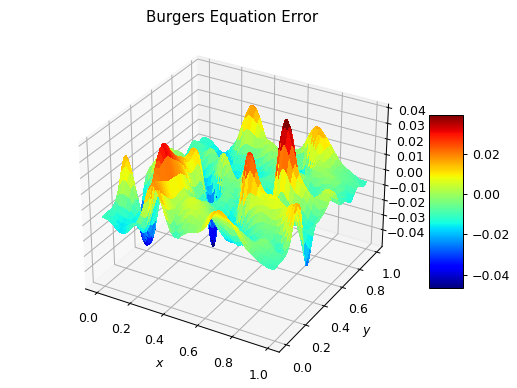

In [59]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
surf = ax.plot_surface(X, Y, pred[..., -1] - true[..., -1], cmap='jet', linewidth=0, antialiased=False)
# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(surf, ax=ax)
fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax.get_zlim()
ax.set_zlim(zlim)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation Error')
# plt.axis('square')
plt.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
    surf = ax.plot_surface(X, Y, pred[..., i] - true[..., i], cmap='jet', linewidth=0, antialiased=False)
    ax.set_zlim(zlim)
#     plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
#     ax.set_zlabel('$u$')
    plt.title(f'Burgers Equation Error')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>


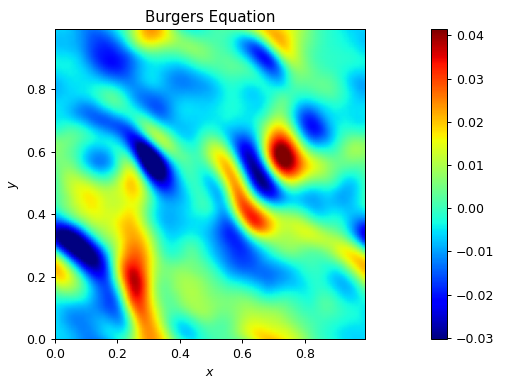

In [60]:
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


# x = torch.linspace(0, 1, Nx + 1)[:-1]
# y = torch.linspace(0, 1, Nx + 1)[:-1]
# X, Y = torch.meshgrid(x, y, indexing='ij')
# # u = U[key].cpu().numpy()
# u0

pcm = ax.pcolormesh(X, Y, pred[..., 0] - true[..., 0], cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(pcm, ax=ax)
# ax.
clim = pcm.get_clim()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation')
plt.axis('square')
plt.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
    pcm = ax.pcolormesh(X, Y, pred[..., i] - true[..., i], cmap='jet', shading='gouraud')
#     plt.colorbar(pcm, ax=ax)
    pcm.set_clim(clim)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Burgers Equation')
    plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)

In [61]:
def plot_predictions(key, key_t, test_x, test_y, preds_y, print_index=False, save_path=None):
    pred = preds_y[key]
    true = test_y[key]


    a = test_x[key]
    # Nt, Nx, _ = a.shape
    u0 = a[..., 0, -1]
    pred_t = pred[..., key_t]
    true_t = true[..., key_t]
    # T = a[:,:,2]
    # X = a[:,:,1]
    # x = X[0]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Nx + 1)[:-1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    t = a[0, 0, key_t, 2]

    # Plot
    fig = plt.figure(figsize=(24,5))
    plt.subplot(1,4,1)

    plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Intial Condition $u(x,y)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, Y, true_t, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Exact $s(x,y,t={t:.2f})$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, Y, pred_t, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Predict $s(x,y,t={t:.2f})$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, Y, pred_t - true_t, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

    


<IPython.core.display.Javascript object>


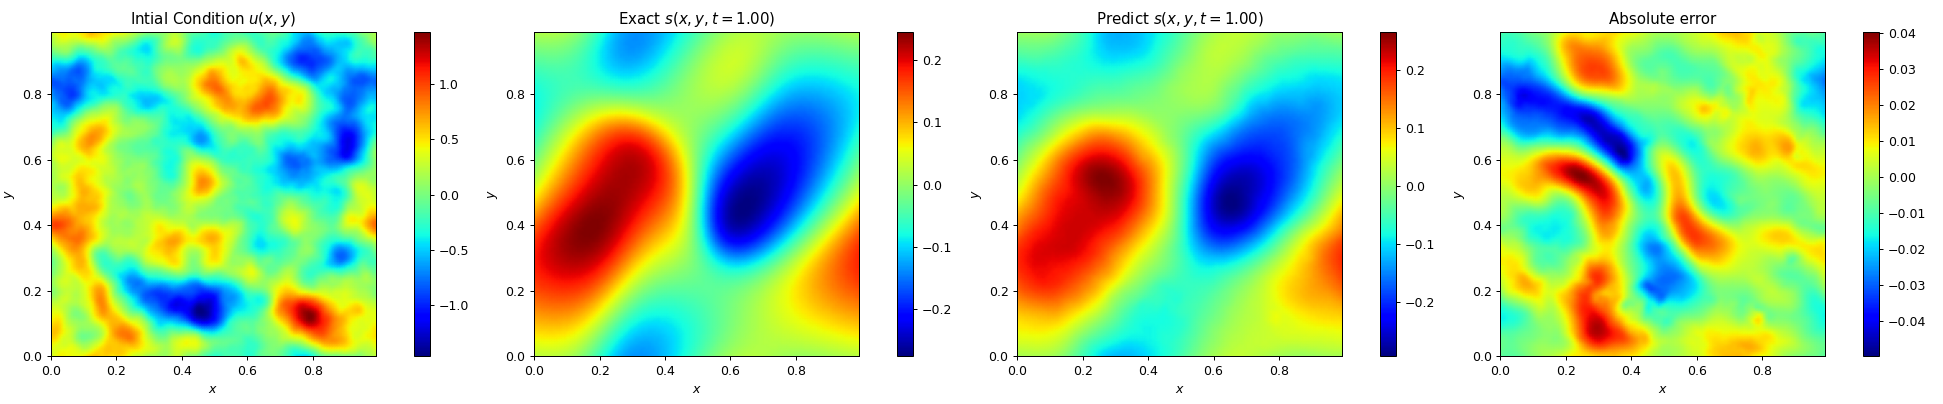

<IPython.core.display.Javascript object>


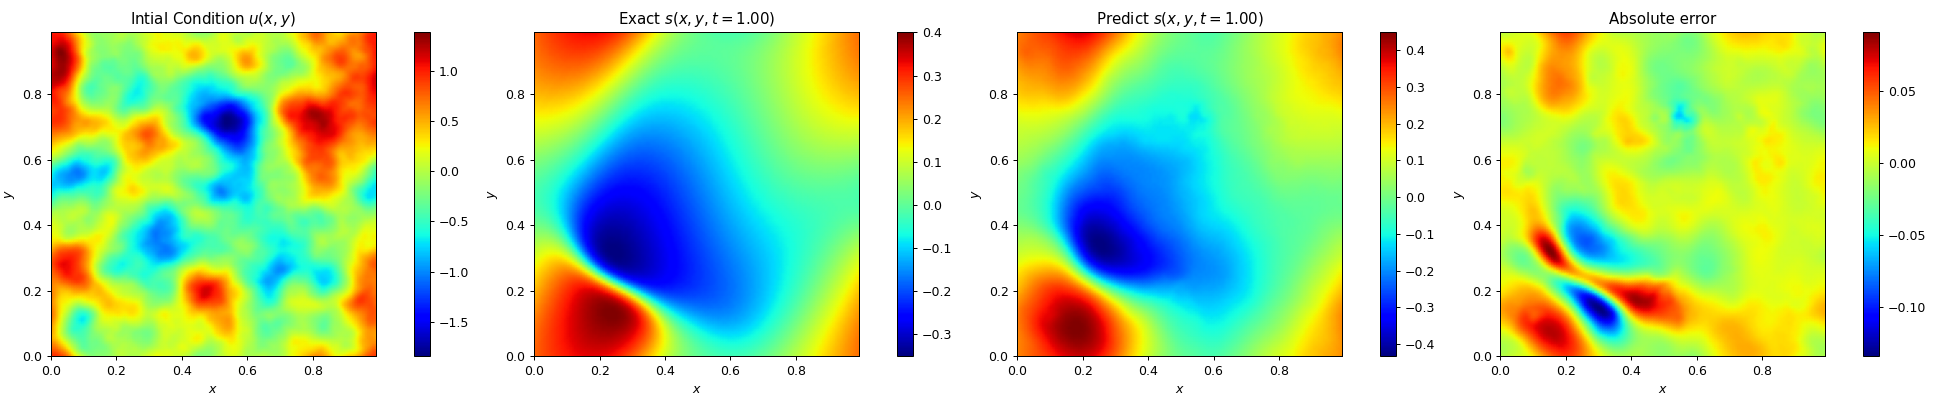

<IPython.core.display.Javascript object>


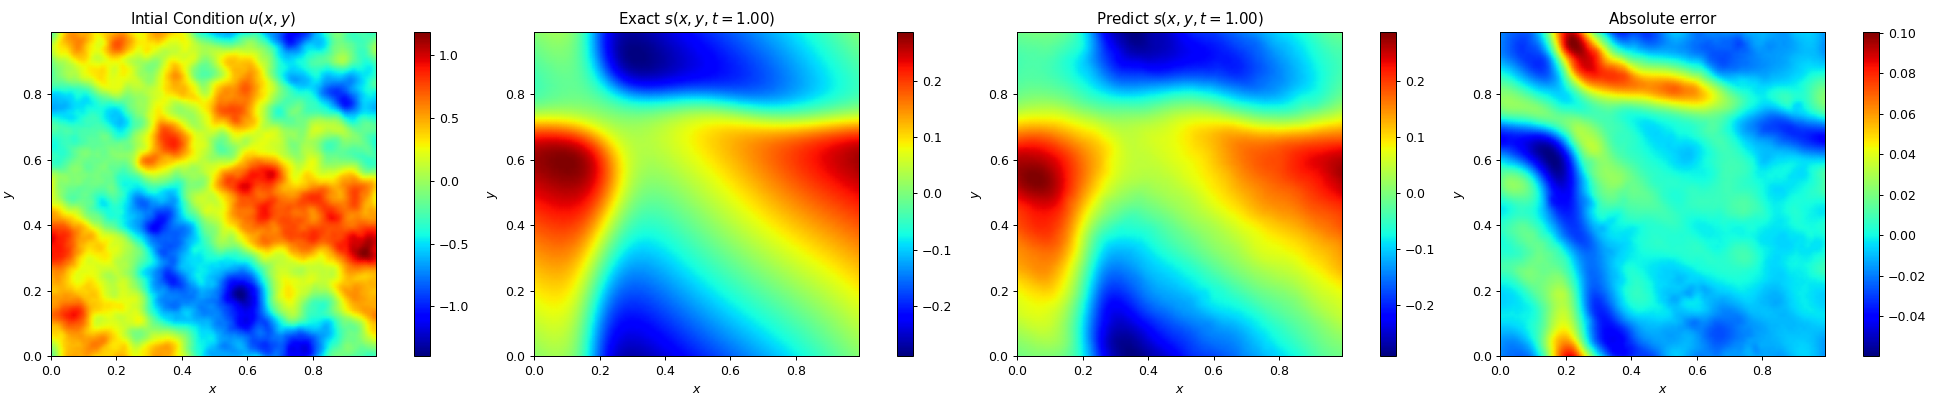

<IPython.core.display.Javascript object>


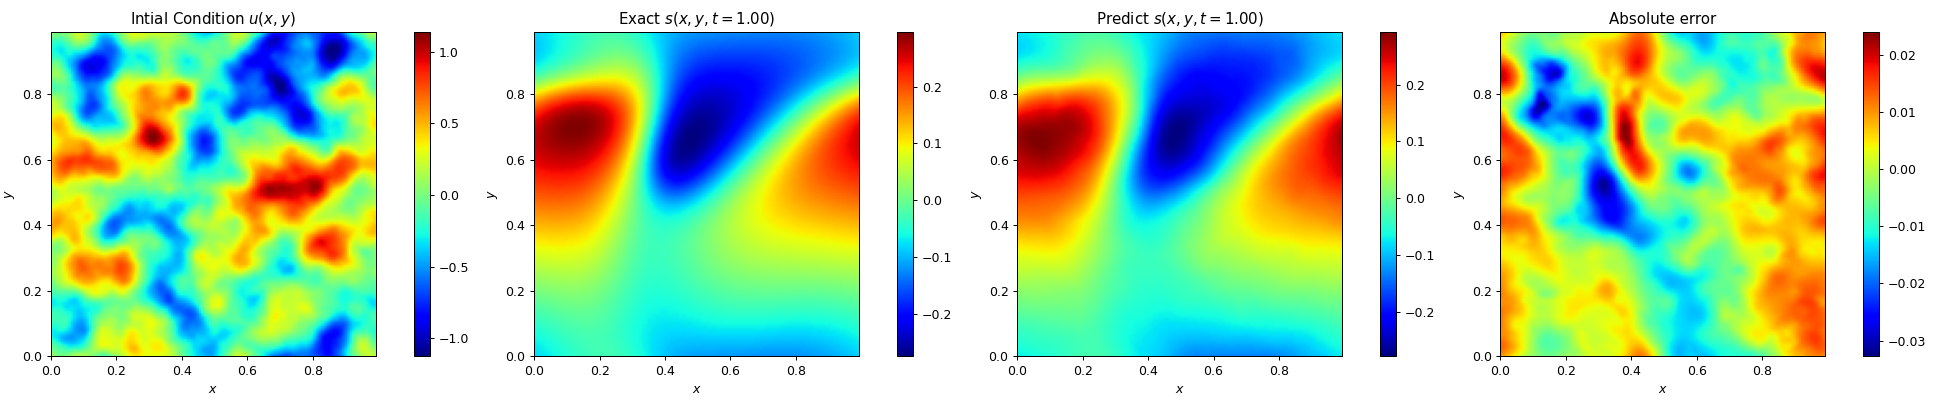

<IPython.core.display.Javascript object>


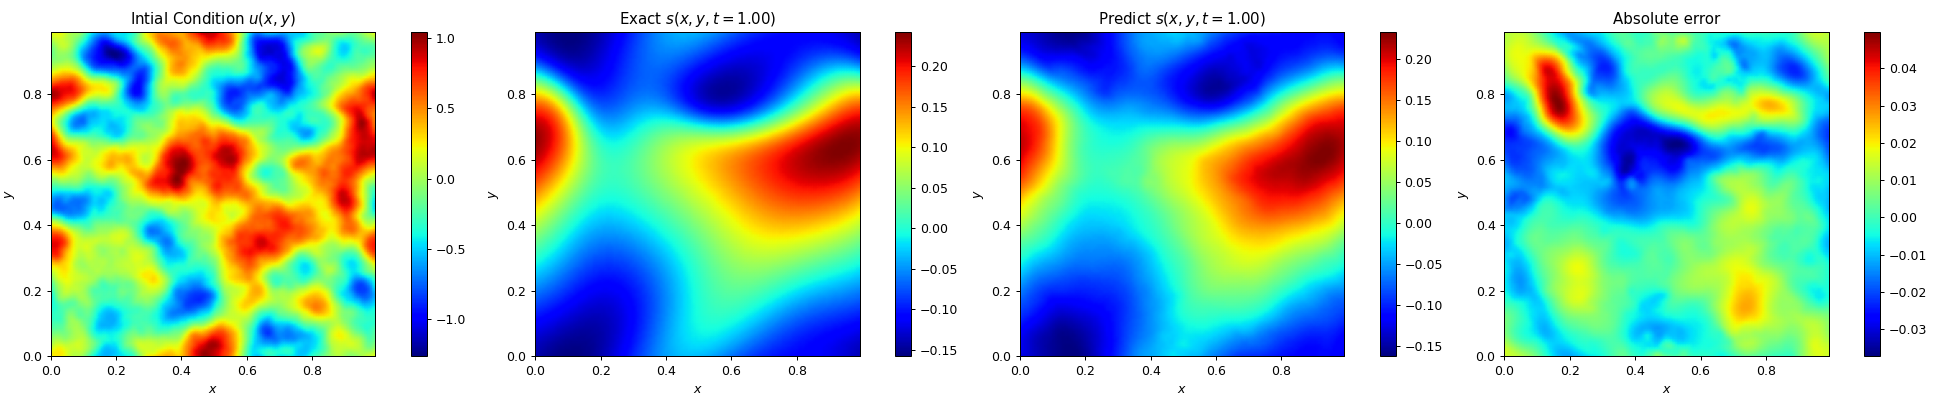

In [62]:
figures_dir = 'Burgers2D/figures/'
os.makedirs(figures_dir, exist_ok=True)
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Burgers{key}')
    plot_predictions(key, key_t, test_x, test_y, preds_y, print_index=True, save_path=save_path)
